# Task 5 :- US Accidents: Road / Weather / Time Analysis

Analyze traffic accident data to identify patterns related to road conditions, weather, and time of day. Visualize accident hotspots and contributing factors.

In [18]:
# Install required packages

!pip install pandas numpy matplotlib seaborn folium scikit-learn plotly geopandas

In [19]:
# Imports and display settings

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# pandas display

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)
plt.rcParams['figure.figsize'] = (10, 6)

In [20]:
# Load a sample (first pass) with dtype inference disabled (to inspect columns)

DATA_PATH = "US_Accidents_March23.csv"

sample = pd.read_csv(DATA_PATH, nrows=100)
print('Columns (sample):', sample.columns.tolist())
print('\nSample dtypes:\n', sample.dtypes)

# Display sample head

sample.head()

Columns (sample): ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

Sample dtypes:
 ID                        object
Source                    object
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)      

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [21]:
# Memory-optimized full load

date_cols = ['Start_Time', 'End_Time']
parse_dates = date_cols

# We'll let pandas infer other dtypes. If memory is an issue, cast floats to float32, ints to int32 after loading.

df = pd.read_csv(DATA_PATH, parse_dates=parse_dates)
print('Rows, cols:', df.shape)


Rows, cols: (7728394, 46)


In [22]:
# Quick overview and null counts

print(df.info(memory_usage='deep'))

null_summary = df.isna().sum().sort_values(ascending=False)
null_summary.head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

End_Lat                  3402762
End_Lng                  3402762
Precipitation(in)        2203586
Wind_Chill(F)            1999019
Wind_Speed(mph)           571233
Visibility(mi)            177098
Wind_Direction            175206
Humidity(%)               174144
Weather_Condition         173459
Temperature(F)            163853
Pressure(in)              140679
Weather_Timestamp         120228
Nautical_Twilight          23246
Civil_Twilight             23246
Sunrise_Sunset             23246
Astronomical_Twilight      23246
Airport_Code               22635
Street                     10869
Timezone                    7808
Zipcode                     1915
City                         253
Description                    5
Traffic_Signal                 0
Roundabout                     0
Station                        0
Stop                           0
Traffic_Calming                0
Country                        0
Turning_Loop                   0
No_Exit                        0
dtype: int

In [23]:
# Keep only columns relevant to this analysis

keep_cols = [
    'ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'State', 'City',
    'Side', 'Turning_Loop', 'Visibility(mi)', 'Weather_Condition', 'Temperature(F)', 'Wind_Chill(F)',
    'Humidity(%)', 'Pressure(in)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
    'Sunrise_Sunset', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
    'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop'
]

# Some columns may not exist in older/newer versions; intersect to avoid errors

keep_cols = [c for c in keep_cols if c in df.columns]
print('Keeping columns:', keep_cols)

df = df[keep_cols].copy()

Keeping columns: ['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'State', 'City', 'Turning_Loop', 'Visibility(mi)', 'Weather_Condition', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Sunrise_Sunset', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']


In [24]:
# 🧹 Basic cleaning and renaming for convenience

# Standardize column names (replace spaces / parentheses)
df.columns = [
    c.replace('(', '')
    .replace(')', '')
    .replace('%', 'pct')
    .replace('/', '_')
    .replace(' ', '_')
    for c in df.columns
]

# 🕒 Convert Start_Time and End_Time to datetime format
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# 🧭 Create derived time features
df['start_date'] = df['Start_Time'].dt.date
df['start_hour'] = df['Start_Time'].dt.hour
df['start_dayofweek'] = df['Start_Time'].dt.day_name()
df['start_month'] = df['Start_Time'].dt.month_name()
df['is_weekend'] = df['Start_Time'].dt.dayofweek >= 5  # Saturday=5, Sunday=6

# 🧾 Quick check
print(df[['Start_Time', 'start_hour', 'start_dayofweek', 'is_weekend']].head())


           Start_Time  start_hour start_dayofweek  is_weekend
0 2016-02-08 05:46:00         5.0          Monday       False
1 2016-02-08 06:07:59         6.0          Monday       False
2 2016-02-08 06:49:27         6.0          Monday       False
3 2016-02-08 07:23:34         7.0          Monday       False
4 2016-02-08 07:39:07         7.0          Monday       False


In [25]:
# Clean weather and numeric columns

numeric_cols = [c for c in df.columns if any(k in c.lower() for k in ['temperature', 'visibility', 'humidity', 'pressure', 'wind_speed', 'precipitation'])]

for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Example: replace visibility 999 or other sentinel values with NaN if present

if 'Visibilitymi' in df.columns:
    df['Visibilitymi'] = df['Visibilitymi'].replace({999: np.nan})

# Summary counts

print('Missing in numeric cols:\n', df[numeric_cols].isna().sum())

Missing in numeric cols:
 Visibilitymi        177098
TemperatureF        163853
Humiditypct         174144
Pressurein          140679
Wind_Speedmph       571233
Precipitationin    2203586
dtype: int64


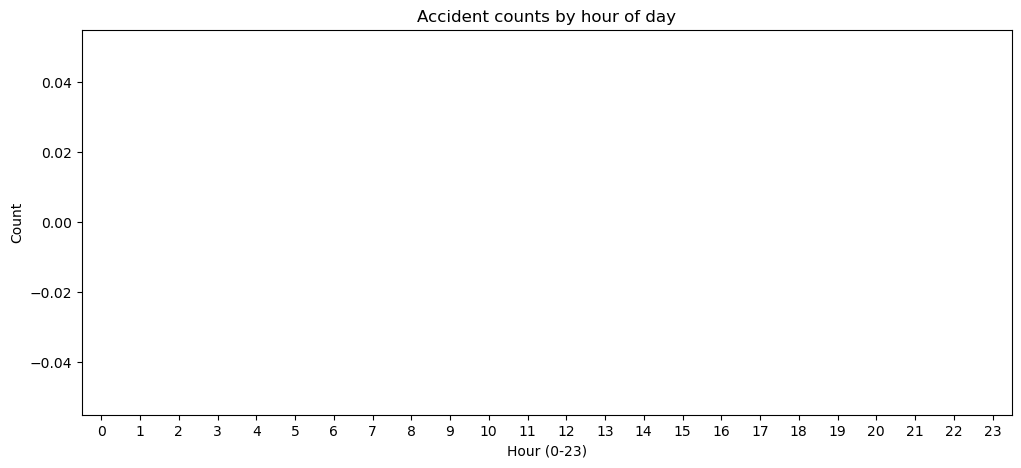

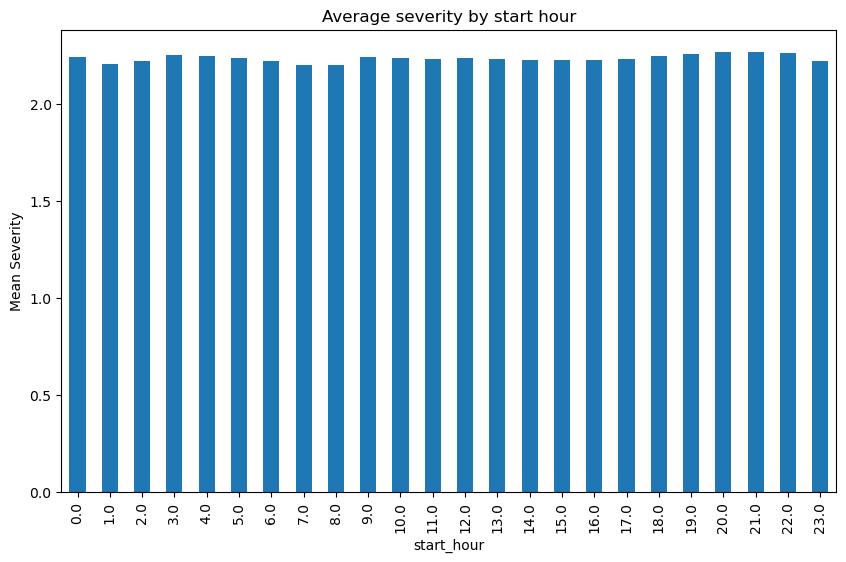

In [26]:
# Exploratory analysis - accidents by hour and severity

plt.figure(figsize=(12,5))
sns.countplot(x='start_hour', data=df, order=range(24))
plt.title('Accident counts by hour of day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Count')
plt.show()

# Severity by hour (mean severity or distribution)

hour_sev = df.groupby('start_hour')['Severity'].mean()
hour_sev.plot(kind='bar')
plt.title('Average severity by start hour')
plt.ylabel('Mean Severity')
plt.show()

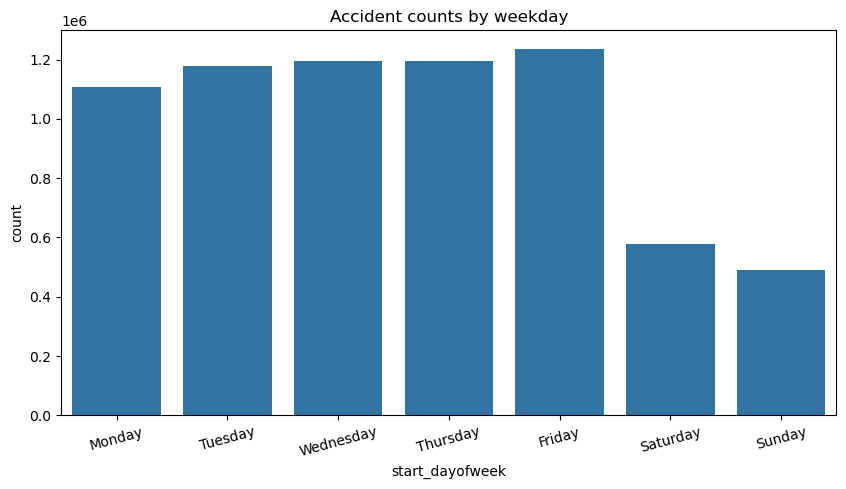

Counts:
is_weekend
False    6659126
True     1069268
Name: count, dtype: int64

Mean severity:
is_weekend
False    2.201860
True     2.277928
Name: Severity, dtype: float64


In [27]:
# Day of week / weekend analysis

plt.figure(figsize=(10,5))
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.countplot(x='start_dayofweek', data=df, order=order)
plt.title('Accident counts by weekday')
plt.xticks(rotation=15)
plt.show()

# Weekend vs weekday counts and mean severity

print('Counts:')
print(df['is_weekend'].value_counts())
print('\nMean severity:')
print(df.groupby('is_weekend')['Severity'].mean())

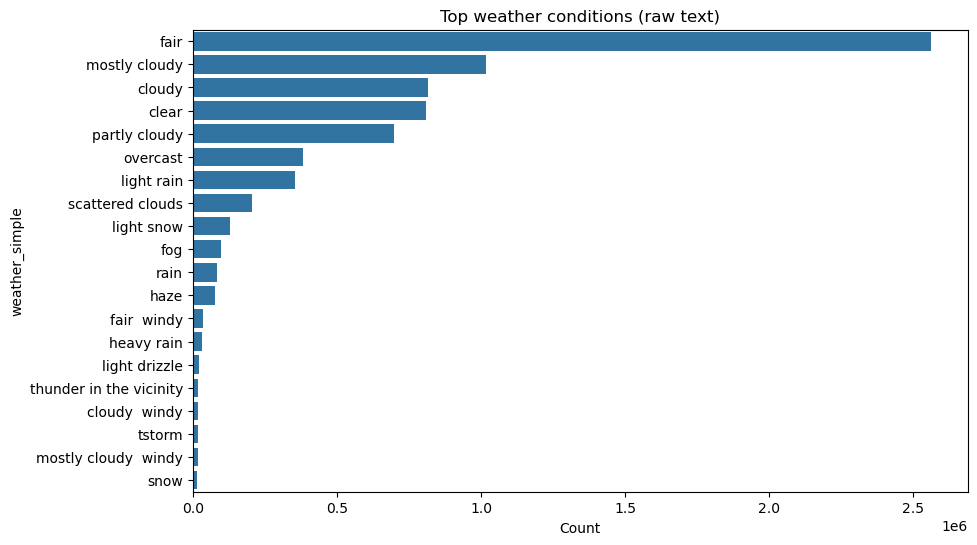

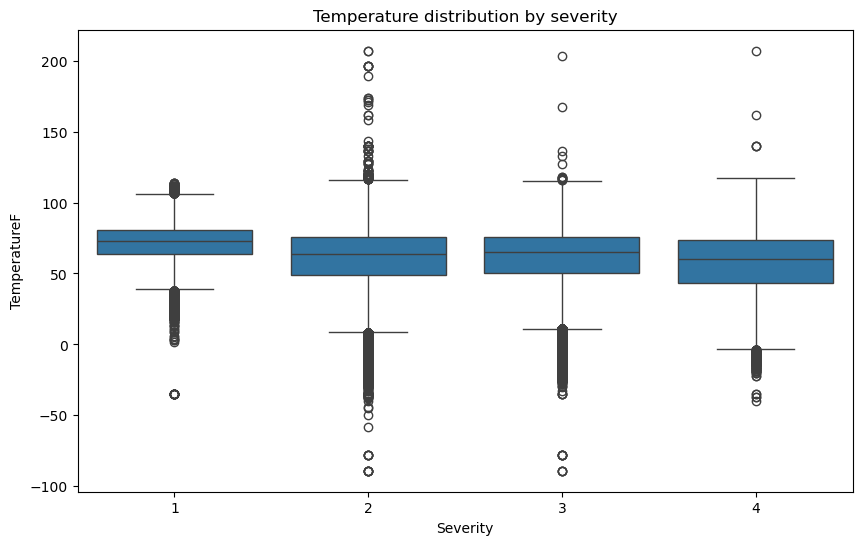

In [28]:
# Weather condition analysis

if 'Weather_Condition' in df.columns:
    # simplify weather strings (lowercase + take first phrase)
    df['weather_simple'] = df['Weather_Condition'].str.lower().str.split(';').str[0].str.replace('[^a-z0-9 ,]','', regex=True)
    top_weather = df['weather_simple'].value_counts().nlargest(20)
    plt.figure(figsize=(10,6))
    sns.barplot(y=top_weather.index, x=top_weather.values)
    plt.title('Top weather conditions (raw text)')
    plt.xlabel('Count')
    plt.show()

# Numeric weather vs severity: temperature

if 'TemperatureF' in df.columns:
    sns.boxplot(x='Severity', y='TemperatureF', data=df)
    plt.title('Temperature distribution by severity')
    plt.show()

In [30]:
# 🚦 Step: Inspect and clean road condition flags

# Define road condition flag columns
road_flags = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction',
    'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
    'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop'
]

# ✅ Ensure only existing, valid columns are used
valid_flags = [c for c in road_flags if c in df.columns and df[c].ndim == 1]
print("Using valid road condition flags:", valid_flags)

# ✅ Inspect counts for each (robust to weird data)
for c in valid_flags:
    try:
        print(f"\n{c} value counts:")
        print(df[c].value_counts(dropna=False).head())
    except Exception as e:
        print(f"⚠️ Skipping {c} due to error: {e}")

# ✅ Convert True/False or 'true'/'false' to 1/0 for numeric aggregation
for c in valid_flags:
    df[c] = df[c].astype(str).str.lower().replace({'true': 1, 'false': 0})
    df[c] = df[c].replace({'nan': 0}).astype(float)


Using valid road condition flags: ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

Amenity value counts:
Amenity
False    7632060
True       96334
Name: count, dtype: int64

Bump value counts:
Bump
False    7724880
True        3514
Name: count, dtype: int64

Crossing value counts:
Crossing
False    6854631
True      873763
Name: count, dtype: int64

Give_Way value counts:
Give_Way
False    7691812
True       36582
Name: count, dtype: int64

Junction value counts:
Junction
False    7157052
True      571342
Name: count, dtype: int64

No_Exit value counts:
No_Exit
False    7708849
True       19545
Name: count, dtype: int64

Railway value counts:
Railway
False    7661415
True       66979
Name: count, dtype: int64

Roundabout value counts:
Roundabout
False    7728145
True         249
Name: count, dtype: int64

Station value counts:
Station
False    7526493
True      201901
Name: count, dtype:

C:\Users\patil\AppData\Local\Temp\ipykernel_10984\933957118.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].astype(str).str.lower().replace({'true': 1, 'false': 0})
C:\Users\patil\AppData\Local\Temp\ipykernel_10984\933957118.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].astype(str).str.lower().replace({'true': 1, 'false': 0})
C:\Users\patil\AppData\Local\Temp\ipykernel_10984\933957118.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future versio

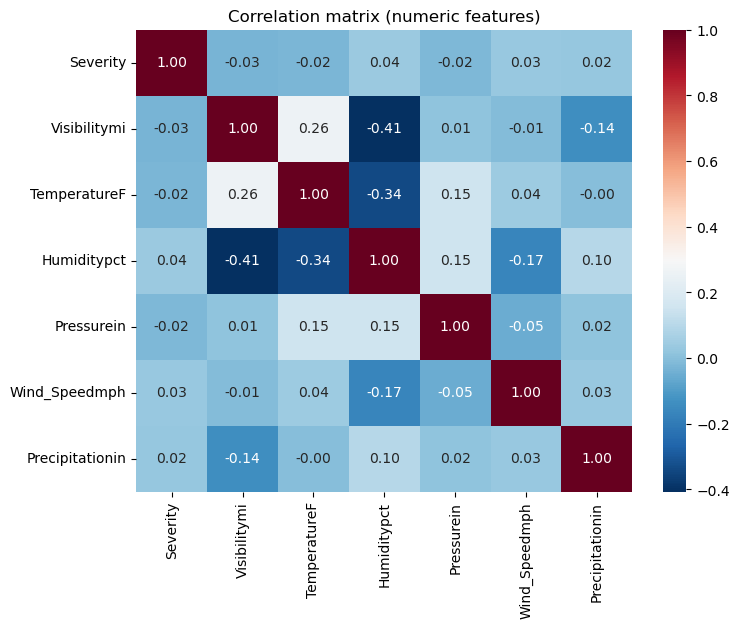

In [31]:
# Correlation matrix for numeric features + severity

num_for_corr = ['Severity'] + [c for c in numeric_cols if c in df.columns]
num_df = df[num_for_corr].dropna()

corr = num_df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r')
plt.title('Correlation matrix (numeric features)')
plt.show()

In [32]:
# Spatial hotspot visualization (sampled) using Folium + MarkerCluster

# Sample points (keep a seed for reproducibility)

sample_size = 50000
if df.shape[0] > sample_size:
    map_df = df[['Start_Lat','Start_Lng','Severity','Start_Time']].dropna().sample(sample_size, random_state=42)
else:
    map_df = df[['Start_Lat','Start_Lng','Severity','Start_Time']].dropna()

# Center map on median coords

center = [map_df['Start_Lat'].median(), map_df['Start_Lng'].median()]
my_map = folium.Map(location=center, zoom_start=5)
mc = MarkerCluster()
for idx, row in map_df.iterrows():
    folium.CircleMarker(location=[row['Start_Lat'], row['Start_Lng']], radius=2,
                        popup=f"Severity: {row['Severity']}\nTime: {row['Start_Time']}", fill=True).add_to(mc)

mc.add_to(my_map)

# Save map to HTML for interactive viewing

map_output = 'accident_hotspots_sample.html'
my_map.save(map_output)
print(f'Map saved to {map_output}. Open this file in your browser to interact.')

Map saved to accident_hotspots_sample.html. Open this file in your browser to interact.


In [33]:
# Density map using Plotly (scatter_mapbox) for visual hotspot heatmap

# For plotly, sample fewer points to be responsive

map_px_df = map_df.sample(min(20000, len(map_df)), random_state=1)
fig = px.density_mapbox(map_px_df, lat='Start_Lat', lon='Start_Lng', z='Severity', radius=8,
                        center=dict(lat=center[0], lon=center[1]), zoom=4,
                        mapbox_style='open-street-map', title='Accident density (sample)')
fig.show()

In [34]:
# Hotspot detection using DBSCAN clustering

coords = df[['Start_Lat','Start_Lng']].dropna()
coords_sample = coords.sample(min(200000, len(coords)), random_state=0)

# Standardize for DBSCAN

scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords_sample)

# DBSCAN with small epsilon (tuned roughly) - eps measured in scaled units

db = DBSCAN(eps=0.03, min_samples=50).fit(coords_scaled)
coords_sample['cluster'] = db.labels_

cluster_counts = coords_sample['cluster'].value_counts().loc[lambda x: x.index != -1].head(20)
print('Top clusters (label: size):')
print(cluster_counts)

# Compute cluster centroids (lat/lon) for top clusters

top_labels = cluster_counts.index.tolist()
centroids = coords_sample[coords_sample['cluster'].isin(top_labels)].groupby('cluster').agg({'Start_Lat':'mean','Start_Lng':'mean','cluster':'count'})
centroids = centroids.rename(columns={'cluster':'count'}).sort_values('count', ascending=False)
centroids.head()

Top clusters (label: size):
cluster
0     44612
1     34329
9     22876
2     22705
6      5236
3      4892
11     4873
4      4245
10     4136
21     3511
5      3390
14     2973
24     2926
18     2674
12     2384
17     2346
40     2055
27     2051
22     1784
15     1674
Name: count, dtype: int64


,Start_Lat,Start_Lng,count
cluster,,,
0,35.595622,-119.468163,44612
1,40.007449,-75.479504,34329
9,27.603720,-81.598531,22876
2,34.604710,-81.234486,22705
6,32.812771,-96.868063,5236


In [35]:
# Map top DBSCAN hotspots

hotspot_map = folium.Map(location=center, zoom_start=5)
for idx, row in centroids.iterrows():
    folium.CircleMarker(location=[row['Start_Lat'], row['Start_Lng']], radius=8,
                        popup=f"Cluster {idx} - {row['count']} accidents", color='red', fill=True).add_to(hotspot_map)

hotspot_map.save('dbscan_hotspots.html')
print('Saved dbscan_hotspots.html')

Saved dbscan_hotspots.html


In [36]:
# Analysis of contributing factors for hotspots

if not centroids.empty:
    top_cluster_label = centroids.index[0]
    # Map labels back to original rows: we'll find nearest points in original df to centroid
    centroid_point = centroids.iloc[0]
    # Compute haversine distance to centroid for all points and take nearest 1000
    def haversine(lat1, lon1, lat2, lon2):
        # returns km
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
        c = 2*np.arcsin(np.sqrt(a))
        return 6371 * c

    distances = haversine(df['Start_Lat'].fillna(0), df['Start_Lng'].fillna(0), centroid_point['Start_Lat'], centroid_point['Start_Lng'])
    local = df.loc[distances < 10]  # within 10 km
    print('Local sample size (within 10 km of top centroid):', local.shape[0])

    # Top weather
    if 'weather_simple' in local.columns:
        print('\nTop weather conditions near hotspot:')
        print(local['weather_simple'].value_counts().head(10))

    # Hours distribution
    print('\nHourly distribution near hotspot:')
    print(local['start_hour'].value_counts().sort_index())

    # Road flags summary
    for c in road_flags:
        if c+'_flag' in local.columns:
            print(f"\n{c} percent nearby:", local[c+'_flag'].mean()*100)

Local sample size (within 10 km of top centroid): 203

Top weather conditions near hotspot:
weather_simple
fair             123
haze              26
smoke             14
clear             14
cloudy             8
fog                7
mostly cloudy      5
light rain         3
partly cloudy      2
overcast           1
Name: count, dtype: int64

Hourly distribution near hotspot:
start_hour
0.0      2
1.0      2
2.0      1
3.0      4
4.0      4
5.0     18
6.0     26
7.0      7
8.0      9
9.0      8
10.0     6
12.0    11
13.0     9
14.0    10
15.0    12
16.0    15
17.0    13
18.0     4
19.0     5
20.0     3
21.0     4
22.0     2
23.0     1
Name: count, dtype: int64


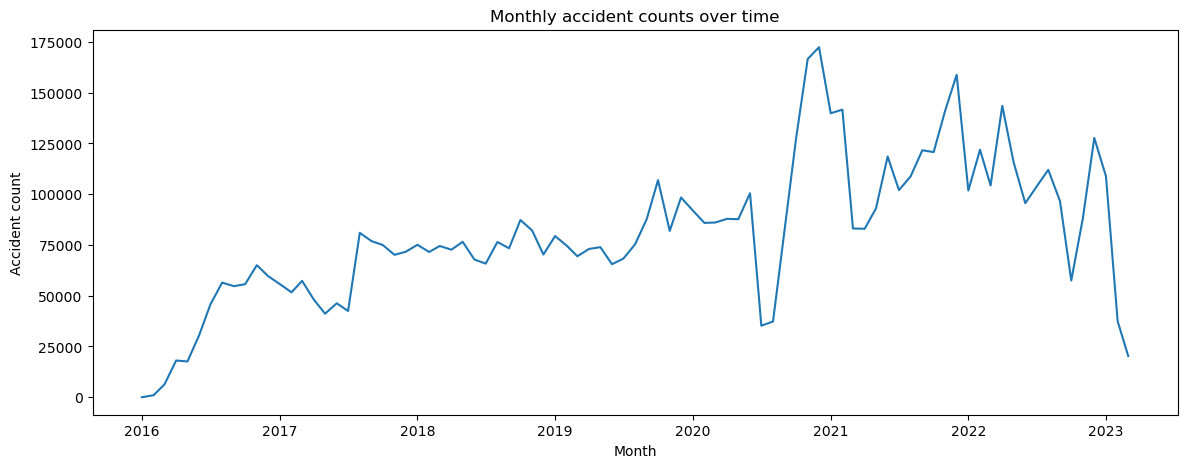

In [37]:
# Time-series seasonal trends (monthly / yearly)

# Create Year-Month

df['year_month'] = df['Start_Time'].dt.to_period('M')
monthly = df.groupby('year_month').size().rename('count').reset_index()
monthly['year_month'] = monthly['year_month'].dt.to_timestamp()

plt.figure(figsize=(14,5))
plt.plot(monthly['year_month'], monthly['count'])
plt.title('Monthly accident counts over time')
plt.xlabel('Month')
plt.ylabel('Accident count')
plt.show()

In [38]:
# Statistical test idea - Are accidents more likely under bad weather?

# Create simple weather labels

if 'weather_simple' in df.columns:
    df['weather_label'] = 'other'
    df.loc[df['weather_simple'].str.contains('rain', na=False), 'weather_label'] = 'rain'
    df.loc[df['weather_simple'].str.contains('clear|sunny|fair|cloud', na=False), 'weather_label'] = 'clear'

    pivot = df.groupby('weather_label')['Severity'].agg(['count','mean']).sort_values('count', ascending=False)
    print(pivot.head())

                 count      mean
weather_label                   
clear          6186100  2.197614
other          1033208  2.280892
rain            509086  2.252834


In [39]:
# Export cleaned sample for modeling or sharing

clean_out = 'us_accidents_clean_sample.csv'
cols_to_export = ['ID','Severity','Start_Time','Start_Lat','Start_Lng','State','City','start_hour','start_dayofweek','is_weekend'] + [c for c in numeric_cols if c in df.columns]
cols_to_export = [c for c in cols_to_export if c in df.columns]

df[cols_to_export].sample(min(200000, len(df))).to_csv(clean_out, index=False)
print('Exported cleaned sample to', clean_out)

Exported cleaned sample to us_accidents_clean_sample.csv


# Conclusions & next steps

# Conclusions:

- Peak hours and certain weekdays show higher accident frequency — consider targeted enforcement during those hours.
- Weather (rain/fog/low visibility) is associated with increased counts and sometimes higher mean severity.
- Many accidents cluster geographically (hotspots) — city-level interventions (engineering changes) could reduce concentration.
- Road features such as traffic signals, junctions, and roundabouts appear often near accident records; deeper causal analysis needed.

# Next steps:

1. Build a predictive model (eg. classification/regression) to estimate accident severity using time, weather, and road features.
2. Fuse POI and traffic volume data for richer context.
3. Create dashboards (Streamlit/PowerBI) for stakeholders to interactively explore hotspots and time trends.